# Cars 196 - Multi Class Classification

## Import and define data

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
import keras
import os, sys
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import numpy as np

# Define train data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
train_images_dir = os.path.join('./', 'cars_train')
train_labels_mat = scipy.io.loadmat('cars_train_annos.mat')
train_labels_data = [[row.flat[0] for row in line] for line in train_labels_mat['annotations'][0]]
df_train = pd.DataFrame(train_labels_data, columns=columns)
print("\n================================\nTrain Data\n================================\n", df_train)

# Define test data
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
test_images_dir = os.path.join('./', 'cars_test')
test_labels_mat = scipy.io.loadmat('cars_test_annos.mat')
test_labels_data = [[row.flat[0] for row in line] for line in test_labels_mat['annotations'][0]]
df_test = pd.DataFrame(test_labels_data, columns=columns) 
print("\n================================\nTest Data\n================================\n", df_test)


Using TensorFlow backend.



Train Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2  class      fname
0          39      116      569      375     14  00001.jpg
1          36      116      868      587      3  00002.jpg
2          85      109      601      381     91  00003.jpg
3         621      393     1484     1096    134  00004.jpg
4          14       36      133       99    106  00005.jpg
...       ...      ...      ...      ...    ...        ...
8139        3       44      423      336     78  08140.jpg
8140      138      150      706      523    196  08141.jpg
8141       26      246      660      449    163  08142.jpg
8142       78      526     1489      908    112  08143.jpg
8143       20      240      862      677     17  08144.jpg

[8144 rows x 6 columns]

Test Data
       bbox_x1  bbox_y1  bbox_x2  bbox_y2      fname
0          30       52      246      147  00001.jpg
1         100       19      576      203  00002.jpg
2          51      105      968      659  00003.jpg
3          67       84      581   

## Generate data based on data set, only run once

In [2]:

# for directory in range(1, 197):
#    path = './cars_train/' + str(directory)
#    os.mkdir(path, 755)
#    path2 = './cars_test/' + str(directory)
#    os.mkdir(path2, 755)


In [3]:
# count = 0

# class_names = [item for item in df_train['class']]
# class_filenames = [item for item in df_train['fname']]


In [4]:


# for name in class_filenames:
#     if count < 2000:
#         old_path = "./cars_train/" + name
#         new_path = "./cars_test/" + str(class_names[count]) + "/" + name
#         os.rename(old_path, new_path)
#     elif count < 4000:
#         old_path = "./cars_train/" + name
#         new_path = "./cars_train/" + str(class_names[count]) + "/" + name
#         os.rename(old_path, new_path)
#     elif count >= 4000:
#         break
    
#     count += 1


## Declare hyper params and image generators

In [2]:
# Try out CNN
batch_size = 64
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Rescale the images
train_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

# Run images through the image generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical')


Found 6144 images belonging to 196 classes.
Found 2000 images belonging to 196 classes.


## Look at them images

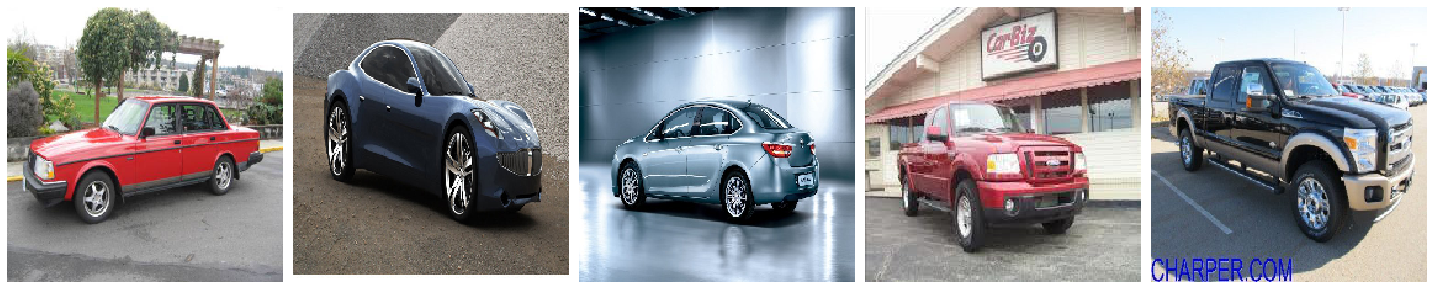

In [3]:
# Visualize training images
sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

## Define keras model

In [7]:
# It's sequential with 3 Convolutional layers and two dense layers.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(196, activation='softmax')
])



In [8]:
# Complile model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View all of the layers of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

## Log the results with tensorboard

In [4]:
logger = keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, histogram_freq=5)

## Train le model

In [10]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=6114 // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=2000 // batch_size,
    callbacks=[logger]
)

Epoch 1/15
95/95 [==============================] - 36s 377ms/step - loss: 5.3476 - accuracy: 0.0064 - val_loss: 5.2482 - val_accuracy: 0.0086
Epoch 2/15
95/95 [==============================] - 35s 366ms/step - loss: 5.1201 - accuracy: 0.0201 - val_loss: 5.1714 - val_accuracy: 0.0171
Epoch 3/15
95/95 [==============================] - 34s 362ms/step - loss: 4.1053 - accuracy: 0.1627 - val_loss: 5.6761 - val_accuracy: 0.0202
Epoch 4/15
95/95 [==============================] - 34s 361ms/step - loss: 1.4324 - accuracy: 0.6808 - val_loss: 8.3520 - val_accuracy: 0.0247
Epoch 5/15
95/95 [==============================] - 34s 358ms/step - loss: 0.2496 - accuracy: 0.9495 - val_loss: 10.6330 - val_accuracy: 0.0212
Epoch 6/15
95/95 [==============================] - 35s 366ms/step - loss: 0.0971 - accuracy: 0.9885 - val_loss: 10.6202 - val_accuracy: 0.0186
Epoch 7/15
95/95 [==============================] - 34s 353ms/step - loss: 0.0729 - accuracy: 0.9928 - val_loss: 11.1426 - val_accuracy: 0.0

## Do it again with augmentation

Found 6144 images belonging to 196 classes.
Found 2000 images belonging to 196 classes.


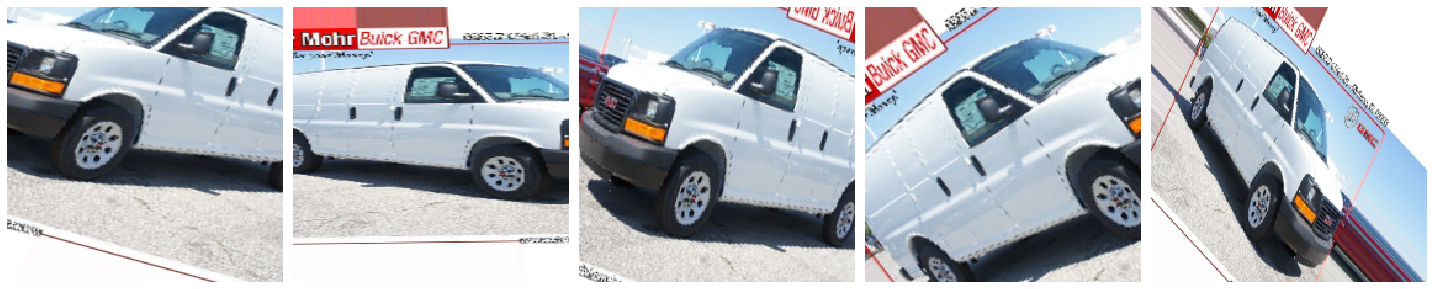

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [ ]:
#Rescale the images
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5
                        )

test_image_generator = ImageDataGenerator(rescale=1./255)

# Run images through the image generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# It's sequential with 3 Convolutional layers and two dense layers.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(196, activation='softmax')
])

# Complile model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View all of the layers of the network
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=6114 // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=2000 // batch_size,
    callbacks=[logger]
)

## Try out 100 epochs

Found 6144 images belonging to 196 classes.
Found 2000 images belonging to 196 classes.


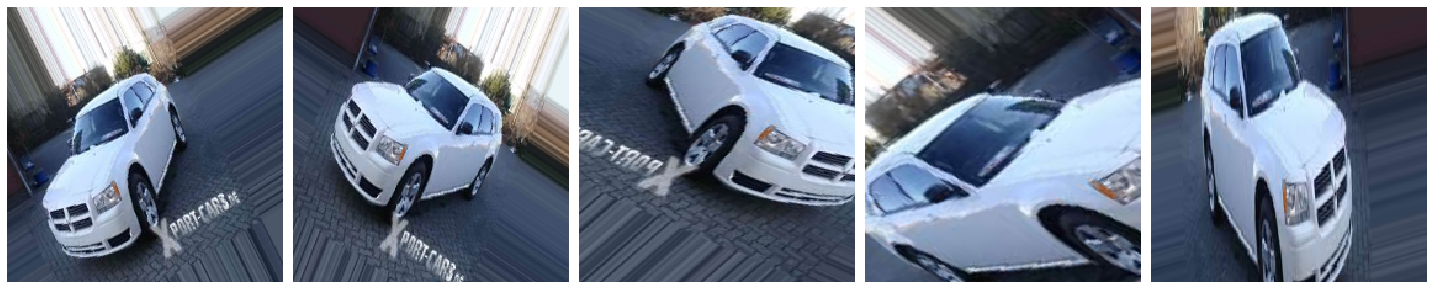

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [12]:
epochs = 100

#Rescale the images
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5
                        )

test_image_generator = ImageDataGenerator(rescale=1./255)

# Run images through the image generators
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_images_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           shuffle=True,
                                                           class_mode='categorical')

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                             directory=test_images_dir,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# It's sequential with 3 Convolutional layers and two dense layers.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(196, activation='softmax')
])

# Complile model 
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View all of the layers of the network
model.summary()

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=6114 // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=2000 // batch_size,
    callbacks=[logger]
)

## Try out the VGG 16

In [4]:
from tensorflow.keras import applications

# This will load the whole VGG16 network, including the top Dense layers.
# Note: by specifying the shape of top layers, input tensor shape is forced
# to be (224, 224, 3), therefore you can use it only on 224x224 images.
vgg_model = applications.VGG16(weights='imagenet', include_top=True)

# If you are only interested in convolution filters. Note that by not
# specifying the shape of top layers, the input tensor shape is (None, None, 3),
# so you can use them for any size of images.
vgg_model = applications.VGG16(weights='imagenet', include_top=False)

# If you want to specify input tensor
from keras.layers import Input
input_tensor = Input(shape=(160, 160, 3))
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# To see the models' architecture and layer names, run the following
vgg_model.summary()

vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(160, 160, 3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block2_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:7]:
    layer.trainable = False

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

vgg_model = applications.VGG16(include_top=True, weights='imagenet')

# Disassemble layers
layers = [l for l in vgg_model.layers]

# Defining new convolutional layer.
# Important: the number of filters should be the same!
# Note: the receiptive field of two 3x3 convolutions is 5x5.
new_conv = Conv2D(filters=64, 
                  kernel_size=(5, 5),
                  name='new_conv',
                  padding='same')(layers[0].output)

# Now stack everything back
# Note: If you are going to fine tune the model, do not forget to
#       mark other layers as un-trainable
x = new_conv
for i in range(3, len(layers)):
    layers[i].trainable = False
    x = layers[i](x)

# Final touch
result_model = Model(input=layer[0].input, output=x)

AttributeError: 'tuple' object has no attribute 'layer'